In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import os
data_dir = 'data/Sketches/input_data/'

2023-04-20 17:17:48.931097: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 17:17:48.932555: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 17:17:48.960420: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 17:17:48.960928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 17:17:49.384283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def merge(im1, im2):
    w = im1.size[0] + im2.size[0]
    h = max(im1.size[1], im2.size[1])
    im = Image.new("RGBA", (w, h))

    im.paste(im1)
    im.paste(im2, (im1.size[0], 0))

    return im

In [3]:
class RulerGenerator:
    def __init__(self, shape, line_width, lines, v_offset, raggedness, color, color_variation, angle):

        lines = lines or 12
        assert 0 <= raggedness <= 1
        assert 0 <= color <= 255
        assert 0 <= color_variation <= 255
        assert -180 <= angle <= 180
        assert 0 <= v_offset <= 1

        w, h = shape
        spacing = shape[1]//lines
        basis = np.array([0]*spacing + [1]*line_width).astype('uint8')
        column = np.tile(basis, 1+int(2*h/len(basis)))[0:2*h]
        lines_array = np.tile(column, 2*w).reshape(2*w, 2*h).T

        color_array = np.random.normal(
            size=(2*h, 2*w))*color_variation + color - color_variation/2
        color_array = color_array.astype('uint8')
        self.color_array = color_array

        ragged_array = 1*(np.random.random(size=(2*h, 2*w))
                          > raggedness).astype('uint8')

        lines_array *= color_array
        lines_array *= ragged_array
        l = 255 - lines_array
        color_offsets = np.random.randint(-60,60, 3)
        red = np.clip(np.where(l==255,255, l/3+color_offsets[0]), 0,255).astype('uint8')
        green = np.clip(np.where(l==255,255,l/3+color_offsets[1]),0,255).astype('uint8')
        blue = np.clip(np.where(l==255,255, l/3+color_offsets[2]),0,255).astype('uint8')
        
        RGB_array = np.stack([red,green,blue], axis =2)
        image = Image.fromarray(RGB_array, mode = 'RGB')
        
        image = image.rotate(angle)

        left = int(w/2)
        right = left + w
        top = int(h/2 + v_offset*len(basis))
        bottom = top + h

        self.image = image.crop((left, top, right, bottom))

In [4]:
def train_data(batch_size=8):
    image_size = (500,500)
    while True:
        X = np.zeros((batch_size, image_size[0], image_size[1], 3))
        Y = np.zeros((batch_size, image_size[0], image_size[1], 3))
        for b in range(batch_size):
            i = np.random.choice(os.listdir(data_dir))
            hflip, vflip, rotate = np.random.choice(('True','False'), 3)

            i = Image.open(data_dir + i)

            if hflip:
                i = i.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            if vflip:
                i = i.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
            if rotate:
                i = i.transpose(Image.Transpose.ROTATE_90)

            red_shift, green_shift, blue_shift = np.random.randint(0,30, 3)

            red = np.array(i)[:,:,0]
            green = np.array(i)[:,:,1]
            blue = np.array(i)[:,:,2]

            red = np.where(red>200, red-red_shift,red)
            green = np.where(green>200, green-green_shift, green)
            blue = np.where(blue>200, blue-blue_shift, blue)

            i = Image.fromarray(np.stack([red,green,blue],axis=2))

            j = ImageEnhance.Contrast(i).enhance(2)
            kwargs = {'shape': image_size,
              'line_width': np.random.randint(1,4),
              'lines': np.random.randint(15,40),
              'v_offset': np.random.random(),
              'raggedness': .3 + np.random.random()/2,
              'color': np.random.randint(100, 150),
              'color_variation': np.random.randint(15, 30),
              'angle': np.random.randint(-10, 11)}
            rg = RulerGenerator(**kwargs)
            j = Image.blend(j, rg.image, .2)
            
            X[b,:,:,:] += np.array(j)/255
            Y[b,:,:,:] += np.array(i)/255
        yield X,Y




In [5]:
X,Y = next(train_data())

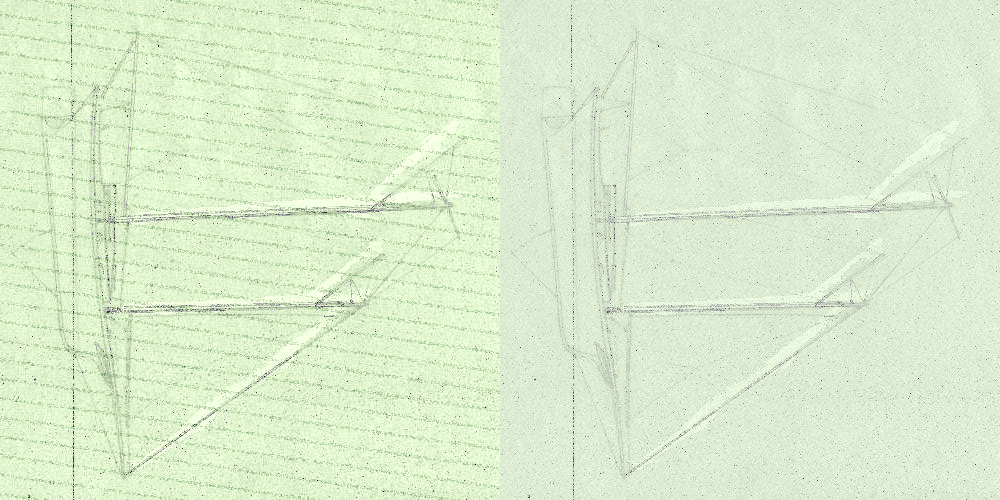

In [6]:
image1 = Image.fromarray((X[0]*255).astype('uint8'))
image2 = Image.fromarray((Y[0]*255).astype('uint8'))
merge(image1, image2)

In [7]:
n=128
model = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same'),
      layers.Reshape((500,500,3))])

model.compile(optimizer='adam', loss=losses.MeanSquaredError())
model.fit(train_data(), steps_per_epoch=1, epochs=1)
model.summary()

2023-04-20 17:17:51.511151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 17:17:51.511674: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-20 17:17:52.141968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

1/1 [==============================] - 4s 4s/step - loss: 0.1346
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 250, 250, 128)    147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 500, 500, 256)    295168    
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 500, 500, 3)       6915      
                                                         

In [ ]:
history = model.fit(train_data(batch_size=8), steps_per_epoch=16, epochs=1000)

Epoch 1/1000


2023-04-20 17:17:56.603491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 55s 3s/step - loss: 0.0353
Epoch 2/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0239
Epoch 3/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0230
Epoch 4/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0261
Epoch 5/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0268
Epoch 6/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0295
Epoch 7/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0269
Epoch 8/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0264
Epoch 9/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0297
Epoch 10/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0291
Epoch 11/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0261
Epoch 12/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0279
Epoch 13/1000
16/16 [=================

16/16 [==============================] - 56s 4s/step - loss: 0.0030
Epoch 102/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0031
Epoch 103/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0027
Epoch 104/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0035
Epoch 105/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0034
Epoch 106/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0039
Epoch 107/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0032
Epoch 108/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0031
Epoch 109/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0031
Epoch 110/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0036
Epoch 111/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0029
Epoch 112/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0025
Epoch 113/1000
16/1

In [ ]:
[plt.plot(v) for k,v in history.history.items()]

In [ ]:
n=32

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
history = autoencoder.fit(train_data(8), steps_per_epoch=16, epochs=1000)

In [ ]:
[plt.plot(v) for k,v in history.history.items()]
# plt.xscale('log');

In [ ]:
plt.hist(autoencoder.predict(X).flatten());

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.encoder.summary()

In [ ]:
autoencoder.decoder.summary()

In [ ]:
image3 = Image.fromarray((autoencoder.predict(X)[0]*255).astype('uint8'))
image4 = Image.fromarray((model.predict(X)[0]*255).astype('uint8'))

merge(merge(merge(image2,image1),image3), image4)

In [ ]:
val = np.random.choice([i for i in os.listdir('data/Sketches/Ruled/') if '.jpg' in i])
print(val)
val = Image.open('data/Sketches/Ruled/'+val).convert('RGB').resize((500,500))
val_X = (np.array(val)/255).reshape(-1,500,500,3)
val_Y = (autoencoder.predict(val_X)[0]*255).astype('uint8')
val_Z = (model.predict(val_X)[0]*255).astype('uint8')
merge(merge(val, Image.fromarray(val_Y)), Image.fromarray(val_Z))